# IMPORT LIBRARIES

In [15]:
# Import relevant libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score,accuracy_score,roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# IMPORT CLASSES

#### DATA PROCESSOR CLASS

Includes the set of all functions to process the data i.e   
* Loading of data    
* Splitting in Train/Test 

In [2]:
class DataProcessor:
    def __init__(self, location, train_file_name, test_file_name, target_col):
        """
        Initialize DataProcessor object.

        Args:
        - location (str): Directory location of the data files.
        - train_file_name (str): Name of the training data file.
        - test_file_name (str): Name of the test data file.
        - target_col (str): Name of the target column in the data.

        Attributes:
        - y (DataFrame): Target variable.
        - X (DataFrame): Features.
        - full_data (DataFrame): Combined dataset of training and test data.
        - train_data (DataFrame): Training data.
        - validation_data (DataFrame): Test data.
        """
        self.y = pd.DataFrame()
        self.X = pd.DataFrame()
        self.full_data = pd.DataFrame()
        self.train_data = pd.DataFrame()
        self.validation_data = pd.DataFrame()
        self.location = location
        self.train_data_file_name = train_file_name
        self.test_data_file_name = test_file_name
        self.target_col = target_col

    def load_data(self):
        """Load training and test data."""
        print("Loading train data")
        self.train_data = pd.read_excel(f"{self.location}/{self.train_data_file_name}")
        print("Train data shape is : {}".format(self.train_data.shape))

        print("Loading test data")
        self.validation_data = pd.read_excel(f"{self.location}/{self.test_data_file_name}")
        print("Test data shape is : {}".format(self.validation_data.shape))

    def combine_test_train(self):
        """Combine training and test data."""
        self.train_data['data_type'] = 'TRAIN'
        self.validation_data['data_type'] = 'TEST'
        self.full_data = pd.concat([self.train_data, self.validation_data], axis=0)
        self.full_data.reset_index(drop=True, inplace=True)
        self.full_data.drop(['Primary key'], axis=1, inplace=True)

    def get_x_y(self):
        """Split features and target variable."""
        self.X = self.train_data.loc[:, self.train_data.columns != self.target_col]
        self.y = self.train_data[self.target_col]

#### FORMAT DATA CLASS

Includes the set of functions for 
* creating features from **transaction columns**
* Extracting features from **account opening date** column

In [3]:
class FormatData:
    def __init__(self, full_data):
        """
        Initialize FormatData object.

        Args:
        - full_data (DataFrame): Full dataset containing all features and target variable.

        Attributes:
        - data (DataFrame): Full dataset.
        - features (DataFrame): Processed features.
        - columns_not_required_for_model (list): Columns not required for modeling.
        - selected_columns (list): Selected columns after processing.
        - correlated_features_table (DataFrame): Table of correlated features.
        - correlated_features_table_binned (DataFrame): Table of binned correlated features.
        - txn_columns (DataFrame): Columns related to transactions.
        """
        self.data = full_data
        self.features = pd.DataFrame()
        self.columns_not_required_for_model = ['Target', 'Primary key']
        self.selected_columns = []
        self.correlated_features_table = pd.DataFrame()
        self.correlated_features_table_binned = pd.DataFrame()
        self.txn_columns = full_data.filter(regex='^txn_', axis=1).fillna(0)

    @staticmethod
    def max_consecutive_zeros(row):
        """Calculate maximum consecutive zeros in a row."""
        max_zeros = 0
        current_zeros = 0
        for value in row:
            if value == 0:
                current_zeros += 1
                max_zeros = max(max_zeros, current_zeros)
            else:
                current_zeros = 0
        return max_zeros

    @staticmethod
    def max_consecutive_non_zeros(row):
        """Calculate maximum consecutive non-zeros in a row."""
        max_non_zeros = 0
        current_non_zeros = 0
        for value in row:
            if value == 1:
                current_non_zeros += 1
                max_non_zeros = max(max_non_zeros, current_non_zeros)
            else:
                current_non_zeros = 0
        return max_non_zeros

    def format_date_column(self, date_column):
        """
        Format date column into separate year, month, day, and weekday columns.

        Args:
        - date_column (str): Name of the date column.
        """
        self.data[date_column] = pd.to_datetime(self.data[date_column])

        # Extract relevant information
        self.features['data_type'] = self.data['data_type']
        self.features['year'] = self.data[date_column].dt.year
        self.features['month'] = self.data[date_column].dt.month
        self.features['day'] = self.data[date_column].dt.day
        self.features['weekday'] = self.data[date_column].dt.weekday

        self.data.drop(date_column, axis=1, inplace=True)

    def txn_details(self):
        """Calculate various statistics related to transaction columns."""
        print("Calculating MEAN, MAX, MIN, MEDIAN, STANDARD DEVIATION, SKEWNESS")
        self.features['mean'] = self.txn_columns.mean(axis=1)
        self.features['max'] = self.txn_columns.max(axis=1)
        self.features['min'] = self.txn_columns.min(axis=1)
        self.features['median'] = self.txn_columns.median(axis=1)
        self.features['std_dev'] = self.txn_columns.std(axis=1)
        self.features['skewness'] = self.txn_columns.skew(axis=1)

        print("Calculating TOTAL, NON-ZERO (COUNT, MEAN), ZERO (COUNT)")
        self.features['total_transactions'] = self.txn_columns.sum(axis=1)
        self.features['non_zero_avg'] = self.txn_columns[self.txn_columns > 0].mean(axis=1)
        self.features['non_zero_count'] = self.txn_columns[self.txn_columns > 0].count(axis=1)
        self.features['non_zero_std'] = self.txn_columns[self.txn_columns > 0].std(axis=1)
        self.features['zero_avg'] = self.txn_columns[self.txn_columns == 0].mean(axis=1)
        self.features['zero_count'] = self.txn_columns[self.txn_columns == 0].count(axis=1)

        # Maximum consecutive zeros
        print("Calculating MAXIMUM NON-ZERO AND ZERO TRANSACTIONS")
        self.features['max_consecutive_zeros'] = self.txn_columns.apply(self.max_consecutive_zeros, axis=1)
        self.features['max_consecutive_non_zeros'] = self.txn_columns.apply(self.max_consecutive_non_zeros, axis=1)
        self.features = self.features.fillna(0)


#### FEATURE ENGINEERING CLASS




In [4]:
class FeatureEngineer:
    def __init__(self, full_data, features):
        """
        Initialize FeatureEngineer object.

        Args:
            full_data (DataFrame): The full dataset containing all features and target variable.
            features (DataFrame): DataFrame containing initial features.
        """
        self.full_data = full_data.drop(['Target'], axis=1)
        self.features = features.copy()
        txn_columns = full_data.filter(regex='^txn_', axis=1).fillna(0)
        self.train_data_txn = txn_columns[full_data['data_type'] == 'TRAIN'].reset_index(drop=True)
        self.validation_data_txn = txn_columns[full_data['data_type'] == 'TEST'].reset_index(drop=True)
        self.train_data = pd.DataFrame()
        self.validation_data = pd.DataFrame()

    def z_score(self):
        """
        Extract Z-score mean.

        Standardize the transactional data using StandardScaler and compute the mean of absolute values.
        """
        print("EXTRACTING Z SCORE MEAN")
        scaler = StandardScaler()
        scaler.fit(self.train_data_txn)
        train_data_scaled = scaler.transform(self.train_data_txn)
        validation_data_scaled = scaler.transform(self.validation_data_txn)
        combined_data = pd.concat([pd.DataFrame(train_data_scaled), pd.DataFrame(validation_data_scaled)], axis=0)
        combined_data.reset_index(drop=True, inplace=True)
        self.features['z_score_mean'] = np.abs(combined_data).mean(axis=1)

    def pca(self, target_variance=0.99):
        """
        Extract PCA components.

        Apply PCA to transactional data and concatenate with existing features.
        """
        print("EXTRACTING PCA")
        pca = PCA(n_components=target_variance)
        pca.fit(self.train_data_txn)
        train_data_pca = pca.transform(self.train_data_txn)
        validation_data_pca = pca.transform(self.validation_data_txn)
        combined_data = pd.concat([pd.DataFrame(train_data_pca), pd.DataFrame(validation_data_pca)], axis=0)
        combined_data.columns = 'pca_' + combined_data.columns.astype(str)
        combined_data.reset_index(drop=True, inplace=True)
        self.features = pd.concat([self.features, combined_data], axis=1)

    def dbscan(self, eps=0.5, min_samples=5):
        """
        Extract DBSCAN labels.

        Perform DBSCAN clustering on transactional data and compute the mean of cluster labels.
        """
        print("EXTRACTING DBSCAN LABELS")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        train_data_dbscan = dbscan.fit_predict(self.train_data_txn)
        validation_data_dbscan = dbscan.fit_predict(self.validation_data_txn)
        combined_data = pd.concat([pd.DataFrame(train_data_dbscan), pd.DataFrame(validation_data_dbscan)], axis=0)
        combined_data.reset_index(drop=True, inplace=True)
        self.features['dbscan_labels'] = np.abs(combined_data).mean(axis=1)

    def kmeans_clustering(self, n_clusters=5):
        """
        Extract KMeans clusters.

        Perform KMeans clustering on transactional data and compute the mean of cluster labels.
        """
        print("EXTRACTING KMEANS CLUSTERS")
        kmeans = KMeans(n_clusters=n_clusters,n_init='auto')
        kmeans.fit(self.train_data_txn)
        train_data_kmeans = kmeans.predict(self.train_data_txn)
        validation_data_kmeans = kmeans.predict(self.validation_data_txn)
        combined_data = pd.concat([pd.DataFrame(train_data_kmeans), pd.DataFrame(validation_data_kmeans)], axis=0)
        combined_data.reset_index(drop=True, inplace=True)
        self.features['kmeans_cluster'] = np.abs(combined_data).mean(axis=1)

    def isolation_forest_anomaly_detection(self, contamination=0.1):
        """
        Extract Isolation Forest anomalies.

        Use Isolation Forest to detect anomalies in transactional data and compute the total anomaly score.
        """
        print("EXTRACTING ISOLATION FOREST")
        iso_forest = IsolationForest(contamination=contamination)
        anomaly_table_train = pd.DataFrame()
        anomaly_table_test = pd.DataFrame()

        for col in self.train_data_txn.columns:
            iso_forest.fit(self.train_data_txn[col].values.reshape(-1, 1))
            anomaly_table_train[f'{col}_anomaly'] = iso_forest.predict(self.train_data_txn[col].values.reshape(-1, 1))
            anomaly_table_test[f'{col}_anomaly'] = iso_forest.predict(self.validation_data_txn[col].values.reshape(-1, 1))

        combined_data = pd.concat([pd.DataFrame(anomaly_table_train), pd.DataFrame(anomaly_table_test)], axis=0)
        combined_data.reset_index(drop=True, inplace=True)
        self.features['total_anomaly_score'] = combined_data.apply(lambda row: (row == -1).sum(), axis=1)

    def fill_missing(self):
        """
        Fill missing values.

        Fill missing values in the dataset with mode for categorical variables and -1 for numerical variables.
        """
        print("FILL MISSING VALUES")
        self.train_data = self.full_data[self.full_data['data_type'] == 'TRAIN'].reset_index(drop=True)
        self.train_data.drop(['data_type'], axis=1, inplace=True)
        self.validation_data = self.full_data[self.full_data['data_type'] == 'TEST'].reset_index(drop=True)
        self.validation_data.drop(['data_type'], axis=1, inplace=True)

        for column in self.train_data.columns:
            if self.train_data[column].dtype == 'object':
                mode_val = self.train_data[column].mode()[0]
                self.train_data[column].fillna(mode_val, inplace=True)
                self.validation_data[column].fillna(mode_val, inplace=True)
            else:
                self.train_data[column].fillna(-1, inplace=True)
                self.validation_data[column].fillna(-1, inplace=True)


#### REMOVE COLUMNS CLASS

In [5]:
class ColumnSelector:
    def __init__(self, train_data, validation_data):
        """
        Initialize ColumnSelector object.

        Args:
            train_data (DataFrame): Training data.
            validation_data (DataFrame): Validation data.
        """
        self.train_data = train_data
        self.validation_data = validation_data

    def remove_constant_columns(self, threshold=0.99):
        """
        Remove constant columns.

        Remove columns from both training and validation dataframes if they have a single dominant value
        exceeding the specified threshold.

        Args:
            threshold (float): Threshold value for dominance percentage (default is 0.99).
        """
        print("REMOVING CONSTANT COLUMNS")
        value_percentages = self.train_data.apply(lambda col: col.value_counts(normalize=True).max(), axis=0)
        constant_columns = value_percentages[value_percentages >= threshold].index.tolist()
        self.train_data.drop(columns=constant_columns, inplace=True)
        self.validation_data.drop(columns=constant_columns, inplace=True)

    def select_correlated_columns(self, target, correlation_threshold):
        """
        Select columns correlated with the target variable.

        Select columns from both training and validation dataframes that have a correlation coefficient
        with the target variable above the specified threshold.

        Args:
            target (Series): Target variable.
            correlation_threshold (float): Threshold value for correlation coefficient.
        """
        print("SELECTING CORRELATED COLUMNS")
        # Concatenate X and y for easy correlation analysis
        data = pd.concat([self.train_data, target], axis=1)

        try:
            # Calculate Pearson correlation matrix
            correlation_matrix = data.corr(numeric_only=True)
        except Exception as e:
            # Calculate Pearson correlation matrix
            correlation_matrix = data.corr()
            
        correlation_matrix = correlation_matrix.fillna(0)
        
        # Select features highly correlated with the target variable
        correlated_features = correlation_matrix[target.name].abs().sort_values(ascending=False)
        non_numeric_columns = list(set(self.train_data.columns) - set(correlated_features.index))
        selected_columns_correlated = list(correlated_features[correlated_features >= correlation_threshold].index)
        selected_columns_correlated.remove("Target")  # Assuming 'Target' is the name of the target variable
        self.train_data = self.train_data[non_numeric_columns + selected_columns_correlated]
        self.validation_data = self.validation_data[non_numeric_columns + selected_columns_correlated]
        print("Removed Columns due to Correlation",selected_columns_correlated)
        print("Remaining columns: {}".format(len(non_numeric_columns + selected_columns_correlated)))

#### MODEL CLASS

In [6]:
class ModelRunner:
    def __init__(self, all_data_categorical_train, y, random_state, model=None):
        """
        Initialize ModelRunner object.

        Args:
            all_data_categorical_train (DataFrame): Features DataFrame for training.
            y (Series): Target variable.
            random_state (int): Random seed for reproducibility.
            model: Optional pre-trained model.
        """
        self.model_data = all_data_categorical_train.copy()
        self.y = y.copy()
        self.random_state = random_state
        self.model = model

    def run_model(self, n_splits=5, n_estimators=200, use_poly=False, cross_validation=False, poly_degree=2):
        """
        Run XGBoost model.

        Args:
            n_splits (int): Number of splits for cross-validation.
            n_estimators (int): Number of XGBoost estimators.
            use_poly (bool): Whether to use polynomial features.
            cross_validation (bool): Whether to perform cross-validation.
            poly_degree (int): Degree of polynomial features if use_poly is True.
        """
        X_train, X_test, y_train, y_test = train_test_split(
            self.model_data, self.y, test_size=0.2, random_state=self.random_state, stratify=self.y
        )

        if use_poly:
            poly = PolynomialFeatures(degree=poly_degree, interaction_only=True)
            X_train = poly.fit_transform(X_train)
            X_test = poly.transform(X_test)

        self.model = XGBClassifier(
            subsample=0.96, n_estimators=n_estimators, min_child_weight=4,
            max_depth=19, learning_rate=0.042, gamma=0.3, colsample_bytree=0.78,
            random_state=self.random_state
        )
        self.model.fit(X_train, y_train)
        y_predictions = self.model.predict(X_test)
        cm = confusion_matrix(y_test, y_predictions)

        print("\nClassification Report:")
        print(classification_report(y_test, y_predictions))
        f1 = f1_score(y_test, y_predictions, average='macro')
        print("\nMacro F1 Score:", f1)

        if cross_validation:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
            accuracy_scores = cross_val_score(self.model, X_train, y_train, cv=skf, scoring='accuracy')
            f1_scores = cross_val_score(self.model, X_train, y_train, cv=skf, scoring='f1_macro')

            mean_accuracy = np.mean(accuracy_scores)
            mean_f1 = np.mean(f1_scores)

            print("Accuracy:", mean_accuracy)
            print("Mean F1 scores:", mean_f1)
            print("F1 scores across {} splits: {}".format(n_splits,f1_scores))
            print("F1 score standard deviation: ", f1_scores.std())
            

# RUN CODE

#### LOAD DATA

In [7]:
random_state = 0

location = './'
data_processor = DataProcessor(
    location,
    train_file_name="Dev_data_to_be_shared.xlsx",
    test_file_name="validation_data_to_be_shared.xlsx",
    target_col='Target'
)
data_processor.load_data()
data_processor.combine_test_train()
data_processor.get_x_y()

Loading train data
Train data shape is : (100000, 178)
Loading test data
Test data shape is : (50000, 177)


#### FORMAT DATA AND EXTRACT TRANSACTION RELATED FEATURES

In [8]:
format_data = FormatData(data_processor.full_data.copy())
format_data.format_date_column(date_column='account_opening_date')
format_data.txn_details()

feature_engineer = FeatureEngineer(full_data=format_data.data.copy(), features=format_data.features.copy())
feature_engineer.z_score()
# feature_engineer.pca()
feature_engineer.dbscan()
feature_engineer.kmeans_clustering()
feature_engineer.isolation_forest_anomaly_detection()
feature_engineer.fill_missing()

Calculating MEAN, MAX, MIN, MEDIAN, STANDARD DEVIATION, SKEWNESS
Calculating TOTAL, NON-ZERO (COUNT, MEAN), ZERO (COUNT)
Calculating MAXIMUM NON-ZERO AND ZERO TRANSACTIONS
EXTRACTING Z SCORE MEAN
EXTRACTING DBSCAN LABELS
EXTRACTING KMEANS CLUSTERS
EXTRACTING ISOLATION FOREST
FILL MISSING VALUES


#### COMBINE ALL FEATURES

In [9]:
# Get data for model
train_data_features = feature_engineer.features[feature_engineer.features['data_type'] == 'TRAIN']
train_data_features.reset_index(drop=True, inplace=True)
test_data_features = feature_engineer.features[feature_engineer.features['data_type'] == 'TEST']
test_data_features.reset_index(drop=True, inplace=True)
train_data_actual = feature_engineer.train_data.copy()
test_data_actual = feature_engineer.validation_data.copy()

# Concat final data
final_train_data = pd.concat([train_data_actual, train_data_features], axis=1)
final_test_data = pd.concat([test_data_actual, test_data_features], axis=1)

#### SELECT IMPORTANT FEATURES

In [10]:
column_selector = ColumnSelector(final_train_data, final_test_data)
column_selector.remove_constant_columns()
column_selector.select_correlated_columns(data_processor.y.copy(), correlation_threshold=0.02)

REMOVING CONSTANT COLUMNS
SELECTING CORRELATED COLUMNS
Removed Columns due to Correlation ['others_13', 'others_7', 'others_25', 'txn_80', 'txn_75', 'others_10', 'mean', 'total_transactions', 'txn_11', 'txn_76', 'txn_12', 'std_dev', 'non_zero_avg', 'others_21', 'others_23', 'non_zero_std', 'max', 'others_12', 'txn_7', 'txn_73', 'z_score_mean', 'txn_5', 'others_6', 'txn_1', 'total_anomaly_score', 'others_24', 'txn_17', 'txn_25', 'others_26', 'txn_8', 'demog_23', 'max_consecutive_non_zeros', 'txn_6', 'demog_9', 'others_22', 'txn_18', 'txn_74', 'zero_count', 'non_zero_count', 'txn_2', 'others_9', 'others_16', 'others_15', 'others_36', 'txn_21', 'others_17', 'txn_26', 'txn_22', 'others_1', 'demog_20', 'txn_81', 'txn_58', 'txn_23', 'txn_19', 'txn_37', 'txn_49', 'txn_72', 'txn_71', 'txn_70', 'txn_50', 'txn_65', 'txn_36', 'txn_35', 'txn_61', 'txn_66', 'txn_55', 'txn_38', 'txn_51', 'txn_15', 'txn_33', 'txn_62', 'txn_67', 'txn_24', 'max_consecutive_zeros', 'txn_53', 'txn_9', 'demog_21', 'txn_27

#### CONVERT TO CATEGORICAL VALUES

In [11]:
column_selector.train_data['data_type'] = 'TRAIN'
column_selector.validation_data['data_type'] = 'TEST'
all_data = pd.concat([column_selector.train_data, column_selector.validation_data], axis=0)
print("Total data size : {}".format(all_data.shape))

# Create dummy variables
categorical_columns = all_data.select_dtypes(include=['object']).columns
all_data_categorical = pd.get_dummies(all_data, columns=categorical_columns, drop_first=False)

all_data_categorical_train = all_data_categorical[all_data_categorical['data_type_TEST'] == False]
all_data_categorical_train.drop(['data_type_TEST', 'data_type_TRAIN'], axis=1, inplace=True)
all_data_categorical_test = all_data_categorical[all_data_categorical['data_type_TEST'] == True]
all_data_categorical_test.drop(['data_type_TEST', 'data_type_TRAIN'], axis=1, inplace=True)
print("Total columns after one hot encoding: {}".format(all_data_categorical_test.shape))

Total data size : (150000, 128)


/var/folders/fs/1_sgn68n2914x1m2zltpc2m80000gn/T/ipykernel_7479/3044335152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column_selector.train_data['data_type'] = 'TRAIN'
/var/folders/fs/1_sgn68n2914x1m2zltpc2m80000gn/T/ipykernel_7479/3044335152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column_selector.validation_data['data_type'] = 'TEST'


Total columns after one hot encoding: (50000, 187)


/var/folders/fs/1_sgn68n2914x1m2zltpc2m80000gn/T/ipykernel_7479/3044335152.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_categorical_train.drop(['data_type_TEST', 'data_type_TRAIN'], axis=1, inplace=True)
/var/folders/fs/1_sgn68n2914x1m2zltpc2m80000gn/T/ipykernel_7479/3044335152.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_categorical_test.drop(['data_type_TEST', 'data_type_TRAIN'], axis=1, inplace=True)


# Baseline Model

Taking **all the features** combined 

##### RUN BASE MODEL AND SELECT IMPORTANT FEATURES

In [12]:
base_model = ModelRunner(all_data_categorical_train, data_processor.y.copy(), random_state=random_state)
base_model.run_model(n_splits=10, n_estimators=500, use_poly=False, cross_validation=False)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19600
           1       0.94      0.92      0.93       400

    accuracy                           1.00     20000
   macro avg       0.97      0.96      0.96     20000
weighted avg       1.00      1.00      1.00     20000


Macro F1 Score: 0.9639323246750302


# Stacking 

Stacking Classifier    
**Base Learner**: RandomForestClassifier, XGBoostClassifier, CatBoostingClassifier    
**Meta Learner**: XGBoostClassifier   



In [13]:
# to calculate all relevant features 
# to be used in Stacking Classifier and Xgboost Final Classifier
feature_importances = base_model.model.feature_importances_
importance_df = pd.DataFrame({'Feature': all_data_categorical_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
features_final = list(importance_df[importance_df['Importance'] > 0]['Feature'].values)
print(importance_df.head(10))

           Feature  Importance
30        demog_23    0.339509
22        others_6    0.181657
167  demog_40_High    0.070081
17       others_12    0.065963
0        others_13    0.035899
4           txn_75    0.018725
3           txn_80    0.017338
49        demog_20    0.010103
168   demog_40_low    0.010061
90        others_2    0.008194


In [ ]:

def stackingclassifier_runner():
    base_estimators = [
        ('rf', RandomForestClassifier(n_estimators=500,
                                      min_samples_split=17,
                                      min_samples_leaf=2,
                                      max_depth=9,
                                      bootstrap=False,
                                      max_features='sqrt',
                                      random_state=72, 
                                      n_jobs=-1)),
        ('xgb', XGBClassifier(objective='binary:logistic', 
                              verbosity=0,
                              random_state=72,
                              subsample=0.9111111111111111,
                              n_estimators=500,
                              min_child_weight=1,
                              max_depth=12,
                              learning_rate=0.07444444444444444,
                              gamma=0.2777777777777778,
                              colsample_bytree=0.8666666666666667,
                              n_jobs=-1)),
        ('catboost', CatBoostClassifier(iterations=660,
                                      l2_leaf_reg=9.56675921884909,
                                      depth=6,
                                      learning_rate=0.13487796162292515,
                                      random_state=72))
    ]
    
    
    # Define meta learner
    meta_learner = XGBClassifier( objective='binary:logistic',  # for binary classification
                                    verbosity=0,
                                    random_state=72,
                                    subsample=0.9111111111111111,
                                    n_estimators=500,
                                    min_child_weight=1,
                                    max_depth=12,
                                    learning_rate=0.07444444444444444,
                                    gamma=0.2777777777777778,
                                    colsample_bytree=0.8666666666666667,
                                    n_jobs=-1)
    
    
    # Create stacking classifier
    stacking_clf = create_stacking_classifier(base_estimators, meta_learner, StratifiedKFold(n_splits=10, shuffle=True, random_state=72))
    
    # Fit the stacking classifier
    stacking_clf.fit(X_train, y_train)
    
    # Predictions
    y_pred = stacking_clf.predict(X_test)
    
    # Calculate accuracy and F1 macro score
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Macro Score: {f1_macro:.4f}")
    # Calculate AUC-ROC Score
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"AUC ROC Score: {roc_auc:.4f}")


def create_stacking_classifier(base_estimators, meta_learner, cv=5):
    """
    Create a stacking classifier with specified base estimators and meta learner.

    Parameters:
    - base_estimators: list of tuples
        List of tuples where each tuple contains a name and a base estimator.
    - meta_learner: estimator object
        Meta learner to combine predictions from base estimators.
    - cv: int, optional
        Number of cross-validation folds for stacking. Default is 5.

    Returns:
    - stacking_clf: StackingClassifier
        The stacking classifier with specified base estimators and meta learner.
    """
    stacking_clf = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_learner,
        cv=cv
    )
    return stacking_clf

def stratified_train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Perform a stratified train-test split on a DataFrame.

    Parameters:
    - df: DataFrame
        The DataFrame containing the data to split.
    - target_column: str
        The name of the target column.
    - test_size: float, default=0.2
        The proportion of the dataset to include in the test split.
    - random_state: int or None, default=None
        Controls the randomness of the sample. Pass an int for reproducible output.

    Returns:
    - X_train, X_test, y_train, y_test: DataFrames
        The train-test split of the DataFrame.
    """

    # Perform stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        stratify=y, random_state=random_state)
    return X_train, X_test, y_train, y_test


# Assuming df is your DataFrame and 'target' is your target column
X_train, X_test, y_train, y_test = stratified_train_test_split(all_data_categorical_train[features_final], data_processor.y.copy(), test_size=0.2, random_state=0)


stackingclassifier_runner()

# Final Model

Taking top relevant features i.e (116) into account


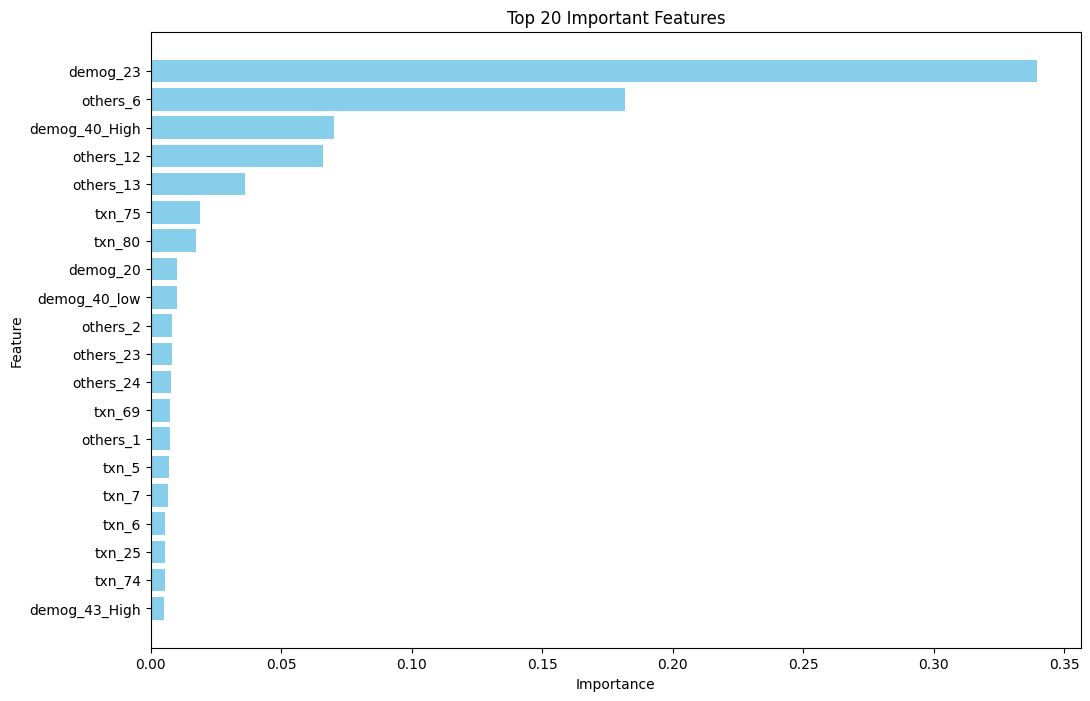

In [16]:
# Sort the DataFrame by importance values
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# You can also visualize the feature importances using a bar plot
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

##### RUN FINAL MODEL

Taking top 116 features 

In [ ]:
model_runner = ModelRunner(all_data_categorical_train[features_final], data_processor.y.copy(), random_state=random_state)
model_runner.run_model(n_splits=10, n_estimators=500, use_poly=False, cross_validation=True)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19600
           1       0.95      0.92      0.93       400

    accuracy                           1.00     20000
   macro avg       0.97      0.96      0.97     20000
weighted avg       1.00      1.00      1.00     20000


Macro F1 Score: 0.966425511445995


#### SAVE SUBMISSION FILE

In [ ]:
submission = pd.DataFrame(
    {
        'primary key': data_processor.validation_data['Primary key'],
        'probability': model_runner.model.predict_proba(all_data_categorical_test[features_final])[:,1],
        'target values': model_runner.model.predict(all_data_categorical_test[features_final])
    }
)

submission.to_csv("{}/result.csv".format(location), index=False)